In [2]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cell 2: Load Data
df = pd.read_csv('used_car.csv')
print("Initial data shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

Initial data shape: (2105, 6)

First few rows:


,car_name,car_price_in_rupees,kms_driven,fuel_type,city,year_of_manufacture
0,Hyundai Grand i10 Magna 1.2 Kappa VTVT [2017-2...,₹ 4.45 Lakh,"22,402 km",Petrol,Mumbai,2016
1,Maruti Suzuki Alto 800 Lxi,₹ 2.93 Lakh,"10,344 km",Petrol,Kolkata,2019
2,Tata Safari XZ Plus New,₹ 22.49 Lakh,"12,999 km",Diesel,Bangalore,2021
3,Maruti Suzuki Ciaz ZXI+,₹ 6.95 Lakh,"45,000 km",Petrol,Thane,2016
4,Jeep Compass Sport Plus 1.4 Petrol [2019-2020],₹ 12 Lakh,"11,193 km",Petrol,Kolkata,2019


In [4]:
# Cell 3: Data Cleaning Functions
def split_car_name(name):
    """Split car name into company and model"""
    two_word_companies = ['Land Rover', 'Mercedes Benz', 'Maruti Suzuki', 
                         'Mercedes-Benz', 'Rolls Royce', 'Mini Cooper']
    name_parts = name.split()
    
    if ' '.join(name_parts[:2]) in two_word_companies:
        company = ' '.join(name_parts[:2])
        model = ' '.join(name_parts[2:])
    else:
        company = name_parts[0]
        model = ' '.join(name_parts[1:])
    
    return pd.Series([company, model])

def clean_price(price_str):
    """Clean price values"""
    if isinstance(price_str, str):
        if 'Lakh' in price_str:
            price_str = price_str.replace('₹', '').replace('Lakh', '').strip()
            return float(price_str) * 100000
        elif 'Crore' in price_str:
            price_str = price_str.replace('₹', '').replace('Crore', '').strip()
            return float(price_str) * 10000000
    return price_str

def clean_kms_driven(kms_str):
    """Clean kilometers driven values"""
    if isinstance(kms_str, str):
        kms_str = kms_str.replace('km', '').replace(',', '').strip()
        return int(kms_str)
    return kms_str

In [5]:
# Cell 4: Initial Data Cleaning
# Split car name
df[['company', 'model']] = df['car_name'].apply(split_car_name)

# Clean price
df['car_price_in_rupees'] = df['car_price_in_rupees'].apply(clean_price)

# Clean kilometers driven
df['kms_driven'] = df['kms_driven'].apply(clean_kms_driven)

# Calculate age
current_year = datetime.datetime.now().year
df['age'] = df['year_of_manufacture'].apply(lambda x: current_year - x)

print("Data cleaning completed")
display(df.head())

Data cleaning completed


,car_name,car_price_in_rupees,kms_driven,fuel_type,city,year_of_manufacture,company,model,age
0,Hyundai Grand i10 Magna 1.2 Kappa VTVT [2017-2...,445000.0,22402,Petrol,Mumbai,2016,Hyundai,Grand i10 Magna 1.2 Kappa VTVT [2017-2020],9
1,Maruti Suzuki Alto 800 Lxi,293000.0,10344,Petrol,Kolkata,2019,Maruti Suzuki,Alto 800 Lxi,6
2,Tata Safari XZ Plus New,2249000.0,12999,Diesel,Bangalore,2021,Tata,Safari XZ Plus New,4
3,Maruti Suzuki Ciaz ZXI+,695000.0,45000,Petrol,Thane,2016,Maruti Suzuki,Ciaz ZXI+,9
4,Jeep Compass Sport Plus 1.4 Petrol [2019-2020],1200000.0,11193,Petrol,Kolkata,2019,Jeep,Compass Sport Plus 1.4 Petrol [2019-2020],6


In [6]:
# Cell 5: Remove Low Frequency Companies
# Count company frequencies
company_counts = df['company'].value_counts()
print("Company frequencies:")
display(company_counts)

# Filter companies with at least 15 occurrences
frequent_companies = company_counts[company_counts >= 15].index
df = df[df['company'].isin(frequent_companies)]

print("\nShape after removing low frequency companies:", df.shape)

Company frequencies:


company
Maruti Suzuki    567
Hyundai          443
Honda            225
Toyota            93
Tata              83
Mercedes-Benz     70
Ford              70
Renault           67
Mahindra          65
Volkswagen        63
Audi              62
BMW               56
Skoda             49
Kia               41
Jeep              30
MG                27
Land Rover        20
Nissan            18
Volvo             13
Datsun            13
Jaguar             9
Chevrolet          6
Isuzu              4
MINI               4
Fiat               3
Porsche            2
Citroen            1
Bentley            1
Name: count, dtype: int64


Shape after removing low frequency companies: (2049, 9)


In [7]:
# Cell 6: Remove Outliers
def remove_outliers(df, columns):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    
    # First ensure all columns are numeric
    for column in columns:
        df_clean[column] = pd.to_numeric(df_clean[column], errors='coerce')
    
    # Drop any rows with NaN values after conversion
    df_clean = df_clean.dropna(subset=columns)
    
    # Now remove outliers
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & 
            (df_clean[column] <= upper_bound)
        ]
        print(f"Rows remaining after cleaning {column}: {len(df_clean)}")
    
    return df_clean

# Remove outliers from numerical columns
numerical_columns = ['car_price_in_rupees', 'kms_driven', 'age']
df = remove_outliers(df, numerical_columns)

print("\nFinal shape after removing outliers:", df.shape)

Rows remaining after cleaning car_price_in_rupees: 1826
Rows remaining after cleaning kms_driven: 1789
Rows remaining after cleaning age: 1781

Final shape after removing outliers: (1781, 9)


In [8]:
# Cell 7: Feature Engineering
# Create interaction features
df['price_per_km'] = df['car_price_in_rupees'] / (df['kms_driven'] + 1)
df['price_per_year'] = df['car_price_in_rupees'] / (df['age'] + 1)
df['km_per_year'] = df['kms_driven'] / (df['age'] + 1)

# Drop unnecessary columns
df = df.drop(['car_name', 'year_of_manufacture'], axis=1)

print("Features after engineering:")
display(df.head())

Features after engineering:


,car_price_in_rupees,kms_driven,fuel_type,city,company,model,age,price_per_km,price_per_year,km_per_year
0,445000.0,22402,Petrol,Mumbai,Hyundai,Grand i10 Magna 1.2 Kappa VTVT [2017-2020],9,19.863411,44500.000000,2240.200000
1,293000.0,10344,Petrol,Kolkata,Maruti Suzuki,Alto 800 Lxi,6,28.322861,41857.142857,1477.714286
3,695000.0,45000,Petrol,Thane,Maruti Suzuki,Ciaz ZXI+,9,15.444101,69500.000000,4500.000000
4,1200000.0,11193,Petrol,Kolkata,Jeep,Compass Sport Plus 1.4 Petrol [2019-2020],6,107.200286,171428.571429,1599.000000
5,372000.0,42906,Petrol,Chennai,Maruti Suzuki,Eeco 5 STR WITH A/C+HTR [2019-2020],8,8.669914,41333.333333,4767.333333


In [9]:
# Cell 8: Prepare Data for Modeling
# Separate features and target
X = df.drop('car_price_in_rupees', axis=1)
y = df['car_price_in_rupees']

# Print unique values in categorical columns before encoding
print("Unique values in categorical columns:")
for col in X.select_dtypes(include=['object']).columns:
    print(f"\n{col}:", X[col].unique())

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Unique values in categorical columns:

fuel_type: ['Petrol' 'Diesel' 'CNG' 'Petrol + 1' 'Diesel + 1' 'Electric' 'Hybrid'
 'LPG']

city: ['Mumbai' 'Kolkata' 'Thane' 'Chennai' 'Bangalore' 'Ahmedabad' 'Hyderabad'
 'Pune' 'Gurgaon' 'Delhi' 'Noida' 'Faridabad' 'Thiruvallur' 'Ambattur'
 'Poonamallee' 'Pallikarnai']

company: ['Hyundai' 'Maruti Suzuki' 'Jeep' 'Toyota' 'Renault' 'Ford' 'Kia' 'Honda'
 'Tata' 'Audi' 'MG' 'BMW' 'Volkswagen' 'Mahindra' 'Nissan' 'Skoda'
 'Mercedes-Benz' 'Land Rover']

model: ['Grand i10 Magna 1.2 Kappa VTVT [2017-2020]' 'Alto 800 Lxi' 'Ciaz ZXI+'
 'Compass Sport Plus 1.4 Petrol [2019-2020]'
 'Eeco 5 STR WITH A/C+HTR [2019-2020]' 'Creta SX Plus 1.6 AT CRDI'
 'Ertiga VXi AT' 'Etios Liva G' 'Kwid 1.0 RXT AMT Opt [2016-2019]'
 'Ciaz VDi+ SHVS' 'Alto 800 LXi (O)' 'Vitara Brezza VDi'
 'Compass Longitude 2.0 Diesel [2017-2020]' 'Corolla Altis VL AT Petrol'
 'Elite i20 Magna Executive 1.2' 'EcoSport Titanium 1.5L Ti-VCT'
 'i10 Magna 1.2 Kappa2' 'Creta 1.6 SX Plus Petrol Sp

In [10]:
# Cell 9: Train and Evaluate Model
# Initialize and train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Model Performance Metrics:")
print(f"R-squared Score: {r2:.4f}")
print(f"Root Mean Squared Error: ₹{rmse:,.2f}")
print(f"Mean Absolute Error: ₹{mae:,.2f}")

Model Performance Metrics:
R-squared Score: 0.8584
Root Mean Squared Error: ₹151,374.73
Mean Absolute Error: ₹108,091.51


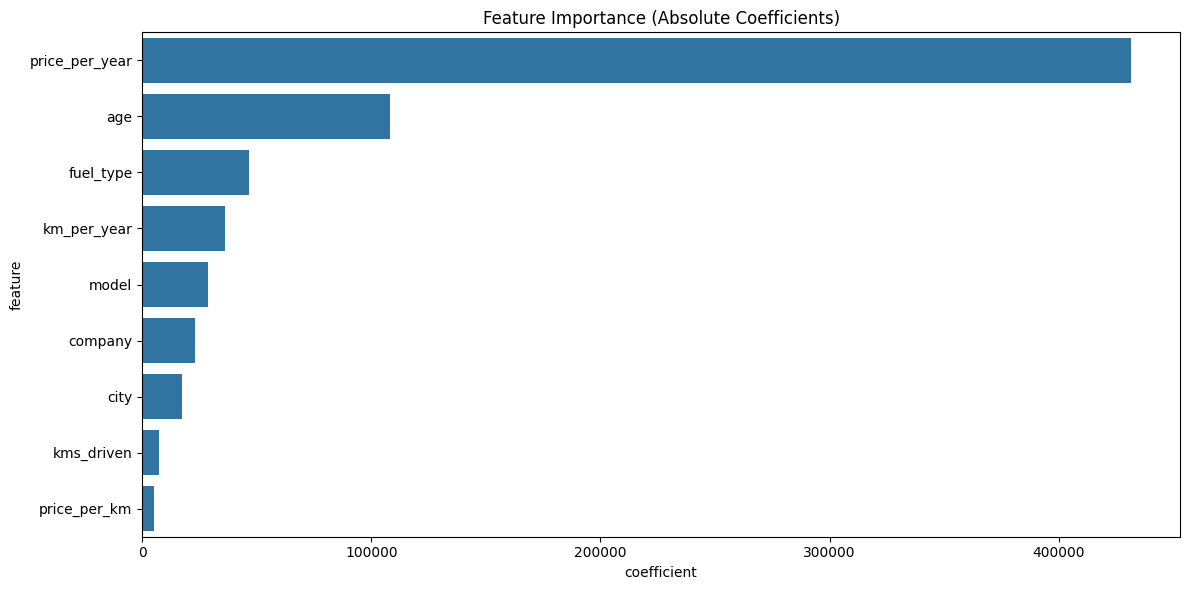

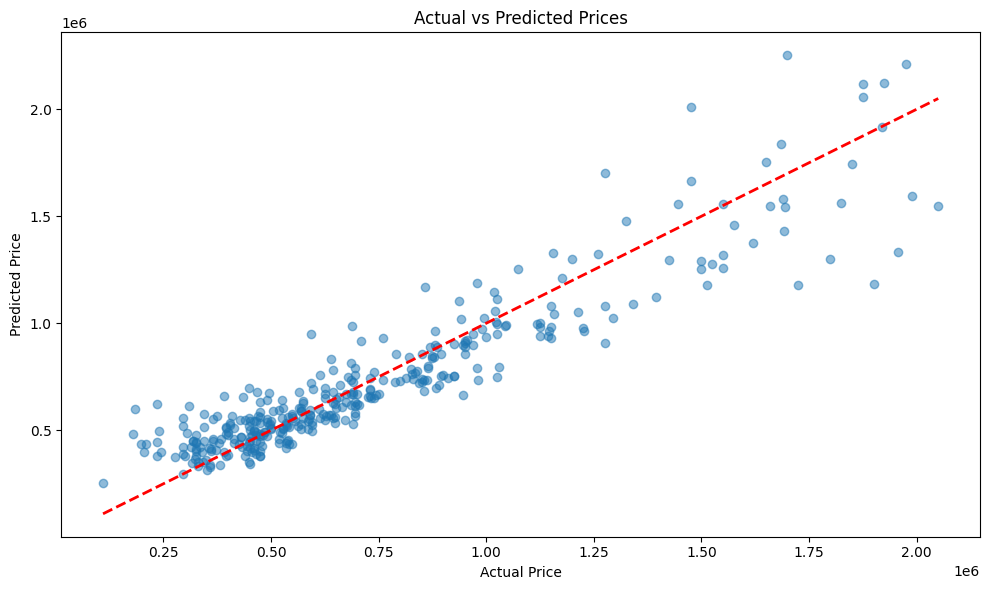

In [11]:
# Cell 10: Visualize Results
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': abs(model.coef_)
})
feature_importance = feature_importance.sort_values('coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='coefficient', y='feature', data=feature_importance)
plt.title('Feature Importance (Absolute Coefficients)')
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

In [13]:
# Cell 11: Function for New Predictions
def predict_car_price(car_details):
    """Predict price for a new car"""
    # Calculate derived features
    car_details['price_per_km'] = car_details.get('price_per_km', 0)
    car_details['price_per_year'] = car_details.get('price_per_year', 0)
    car_details['km_per_year'] = car_details['kms_driven'] / (car_details['age'] + 1)
    
    # Convert input to DataFrame
    input_df = pd.DataFrame([car_details])
    
    # Ensure all columns from training data are present
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[X.columns]
    
    # Encode categorical variables
    for column in categorical_columns:
        if column in input_df.columns:
            try:
                # Check if value exists in encoder classes
                if not all(val in label_encoders[column].classes_ for val in input_df[column].unique()):
                    print(f"Warning: Unknown category in {column}. Using most frequent category instead.")
                    most_frequent = label_encoders[column].classes_[0]
                    input_df[column] = most_frequent
                input_df[column] = label_encoders[column].transform(input_df[column])
            except Exception as e:
                print(f"Error encoding {column}: {str(e)}")
                return None
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)
    
    return prediction[0]

# Example prediction
# First, let's see what models are available in our training data
print("Available models in training data:")
print(label_encoders['model'].classes_)

# Now use one of these models in our prediction
sample_car = {
    'company': 'Maruti Suzuki',
    'model': label_encoders['model'].classes_[0],  # Use first available model
    'fuel_type': 'Petrol',
    'city': 'Mumbai',
    'kms_driven': 50000,
    'age': 5
}

try:
    predicted_price = predict_car_price(sample_car)
    if predicted_price is not None:
        print(f"\nPredicted price for sample car: ₹{predicted_price:,.2f}")
except Exception as e:
    print(f"Error predicting price: {str(e)}")

Available models in training data:
['3 Series 320d Highline Sedan' '3 Series 320d Luxury Line'
 '3 Series 320d Sport Line' '5 Series 520d Luxury Line' '5 Series GT 535d'
 '7 Series 730Ld Sedan' 'A-Star VXI' 'A-Star Vxi'
 'A3 35 TDI Technology + Sunroof' 'A3 40 TFSI Premium'
 'A4 2.0 TDI (143 bhp)' 'A4 2.0 TDI (143bhp)'
 'A4 2.0 TDI (177bhp) Premium' 'A4 2.0 TDI (177bhp) Premium Plus'
 'A4 2.0 TDI Sline' 'A4 35 TFSI Premium Sunroof' 'A6 2.0 TDI Premium'
 'A6 35 TDI Premium' 'Accent Executive' 'Accord 2.4 Elegance MT'
 'Alcazar Prestige (O) 6 STR 2.0 Petrol AT' 'Alto 800 LXi (O)'
 'Alto 800 LXi (O) CNG' 'Alto 800 LXi CNG (O)'
 'Alto 800 LXi CNG [2019-2020]' 'Alto 800 Lxi' 'Alto 800 Lxi CNG'
 'Alto 800 VXi' 'Alto 800 Vxi' 'Alto 800 Vxi Plus' 'Alto K10 LXi'
 'Alto K10 LXi CNG' 'Alto K10 VXi' 'Alto K10 VXi (O)' 'Alto K10 VXi AMT'
 'Alto K10 VXi AMT (Airbag) [2014-2019]' 'Alto K10 VXi AMT [2014-2018]'
 'Alto K10 VXi [2014-2019]' 'Alto LXi BS-III' 'Altroz XT Petrol'
 'Altroz XZ (O) Diesel' 'A

In [14]:
# Cell 12: Save Model and Encoders (Optional)
import pickle

# Save model
with open('car_price_model.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'categorical_columns': categorical_columns
    }, f)

print("Model saved successfully!")

Model saved successfully!
